# Семинар 3 - Алгоритмы предварительной обработки изображений и их реализация

***

In [169]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Свертка (Convolution)

1. Определение

![](https://upload.wikimedia.org/wikipedia/commons/6/6e/Convolution_of_box_signal_with_itself.gif "conv1")

![](https://upload.wikimedia.org/wikipedia/commons/6/67/Convolution_of_spiky_function_with_box.gif "conv2")

$\textbf{Свёртка, конволюция}$ — операция, которая при применении к двум функциям 
$f(x)$ и $g(x)$ возвращает третью функцию, соответствующую взаимнокорреляционной функции $f(x)$ и $g(-x)$. Смысл - "схожесть" одного сигнала с отраженным другим. Другими словами, имеется система, подается на вход сигнал, выход системы - результат свертки.

В компьютерном зрении часто рассматривают как системы - различные фильтры (выделения краев, медианный фильтр и другие). Адаптивно подстраивая их, мы сможем получать нужные выходные сигналы.

Свойства:

1. $f*g = g*f$
2. $f*(g*h) = (f*g)*f*h$
3. $(f_{1}+f_{2})*g = f_{1}*g + f_{2}*g$
4. $(\alpha f)*g = f*(\alpha g)$

Одномерный случай свертки

$$ w(t) = \sum\limits_{\tau=0}^{t} g(\tau)^{*} f(t - \tau) $$

где ${*}$ означает комплексное сопряжение.

2. Теория

Идея свертки основывается на дискретном [преобразовании Фурье](https://ru.wikipedia.org/wiki/Преобразование_Фурье) (ДПФ). Можно разложить сигнал на элементарные составляющие - гармонические колебания с разными частотами. В получившийся частотной области исследовать сигнал проще.

Например, если рассматривать линейные системы, то если мы знаем характеристику системы $F$, то можем при любом входном сигнале $G$ получить выходной сигнал $W$ по формуле в частотной области: $W(w) = G(w)F(w)$

ДПФ прямое: $G(w) = \sum\limits_{t=0}^{N-1} g(t) e^{-\frac{2 \pi i}{N} w t}$.

ДПФ обратное: $g(t) = \frac{1}{N} \sum\limits_{w=0}^{N-1} G_(w) e^{\frac{2\pi i}{N} w t}$.

3. Визуализация в частотной области

Используя формулу Эйлера $e^{j\omega T} = cos(\omega T) + j\cdot sin(\omega T)$, можно определить *вещественную* и *мнимую* составляющие, а также **модуль** и **аргумент** спектральной плотности, которые связаны с вещественной и мнимой частями спектра через формулы теории функции комплексного переменного.

Модуль: $|X(kT)| = \sqrt{Re(X)^2 + Im(X)^2}$

Фаза: $arg(X(kT)) = \arctan{\frac{Im(X)}{Re(X)}}$







### Методы фильтрации изображений

Рассмотрим несколько стандартных моделей шума
1. $\textbf{Соль и перец}$ - случайные черные и белые пиксели
2. $\textbf{Импульсный}$ - случайные белые пиксели
3. $\textbf{Гауссов}$ - колебания яркости, распределенные по нормальному закону

Проанализируем часть из них на одномерных массивах

In [170]:
import ipywidgets
from scipy.fftpack import (
    fft, ifft,
    fft2, ifft2,
    fftshift, ifftshift,
)

def viz_signal(
    signal: list,
) -> None:

    # signal
    x = np.array(signal)

    # Forward FFT
    N = 512
    xFFT = fftshift(fft(x, N))
    # Magnitude spectrum
    xA = np.abs(xFFT)
    # Phase spectrum
    xF = np.angle(xFFT)

    # List of signals
    xT = [x, xA, xF, ]
    lst_title = ['Signal', 'Spectrum [db]', 'Phase']

    # Plot results
    fig = plt.figure(figsize=(20, 10), dpi=80)

    for i, sig in enumerate(xT):
        plt.subplot(2, 2, int(2**i))
        plt.ylabel('Level', fontsize=30)
        plt.title(lst_title[i], fontsize=30)
        if i == 0:
            plt.stem(sig, basefmt='C0')
            plt.xlabel('Time samples', fontsize=30)
        else:
            plt.plot(sig)
            plt.xlabel('Freq samples', fontsize=30)
            plt.xlim([0, N - 1])
        plt.grid()

    plt.tight_layout()

#define signal
N = 128
# time vector
t = np.linspace(0, 1, N)
# freq
f1 = 2
signal = np.cos(2*np.pi*f1*t)

@ipywidgets.interact(
    value=ipywidgets.IntSlider(
        min=-10, max=30,
        step=1, value=signal[N - 1],
    ),
    pos=ipywidgets.IntSlider(
        min=0, max=N,
        step=1, value=N - 1,
    ),
)
def play_with_signal(
    value: int,
    pos: int,
) -> None:

    signal[pos] = value

    viz_signal(signal)

interactive(children=(IntSlider(value=1, description='value', max=30, min=-10), IntSlider(value=127, descripti…

# Упражнение 1  (оцениваемое)

**Это и дальнейшие упражнения и вопросы будут оцениваться**

Реализуйте шумы типа соль/перец и гаусов шум. Визуализируйте результаты - добавьте шум к предложенному изображению астронавта.

In [171]:
#Соль и перец
def saltpepper_noise(
    image: np.array,
    proportion: float=0.2,
) -> np.array:
    salt_pepper_img = image.copy()
    h,w = image.shape
    num_pepper = np.ceil(proportion* image.size * 0.5)
    num_salt = np.ceil(proportion * image.size * 0.5)
    x = np.random.randint(0, h, (int(num_salt)))
    y = np.random.randint(0, w, (int(num_pepper)))
    salt_pepper_img[x[:], y[:]] = 1
    x = np.random.randint(0, h, (int(num_salt)))
    y = np.random.randint(0, w, (int(num_pepper)))
    salt_pepper_img[x[:], y[:]] = 0

    return salt_pepper_img


#Гаусов шум
def gaussian_noise(
    image: np.array,
    mean: float=0.04,
    sigma: float=0.07,
) -> np.array:
    gaussian_img = image.copy()
    gaussian_noise = np.random.normal(mean, sigma, image.shape)
    gaussian_img = gaussian_img + gaussian_noise
    return gaussian_img

def do_nothing(
    image: np.array,
) -> np.array:
    return image

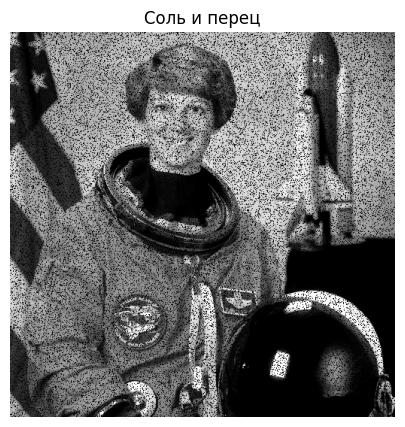

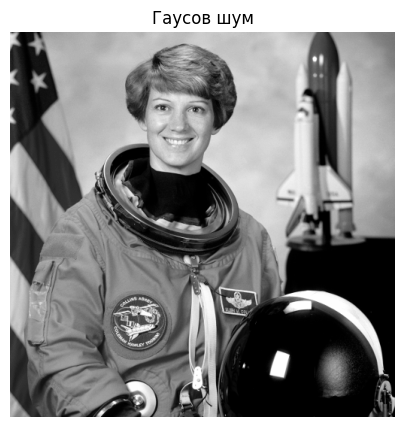

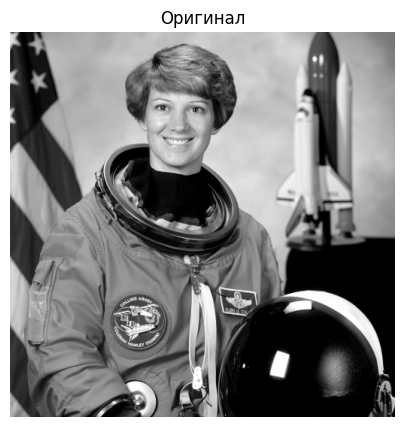

In [172]:
from skimage import data

img = cv2.cvtColor(
    src=data.astronaut(),
    code=cv2.COLOR_RGB2GRAY,
)

# Применение функций
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
ax1.imshow(saltpepper_noise(img), cmap='gray')
ax1.set_title('Соль и перец')
ax1.axis('off')

fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))
ax2.imshow(gaussian_noise(img), cmap='gray')
ax2.set_title('Гаусов шум')
ax2.axis('off')

fig, ax3 = plt.subplots(1, 1, figsize=(15, 5))
ax3.imshow(do_nothing(img), cmap='gray')
ax3.set_title('Оригинал')
ax3.axis('off')

# Отображаем
plt.show()

# Упражнение 2

Посмотрите также разницу на других фотографиях - они доступны в `skimage.data`

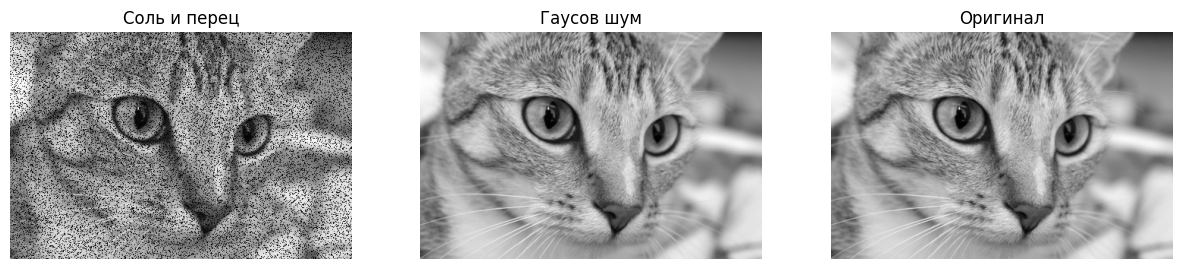

In [173]:
img = cv2.cvtColor(
    src=data.cat(),
    code=cv2.COLOR_RGB2GRAY,
)


# Применение функций
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(saltpepper_noise(img), cmap='gray')
ax1.set_title('Соль и перец')
ax1.axis('off')

ax2.imshow(gaussian_noise(img), cmap='gray')
ax2.set_title('Гаусов шум')
ax2.axis('off')

ax3.imshow(do_nothing(img), cmap='gray')
ax3.set_title('Оригинал')
ax3.axis('off')

plt.show()


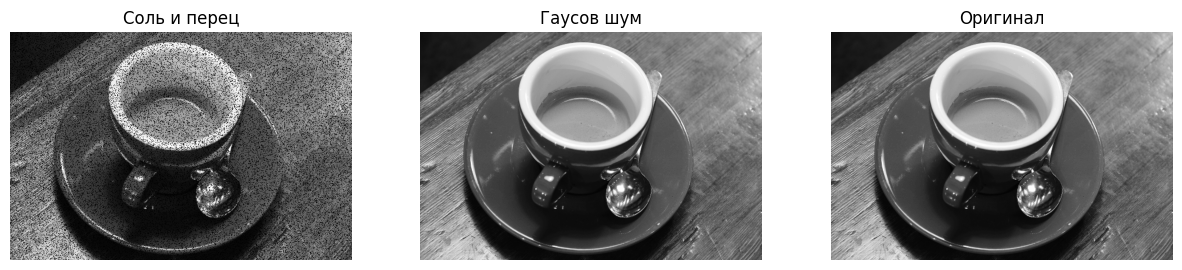

In [174]:
img = cv2.cvtColor(
    src=data.coffee(),
    code=cv2.COLOR_RGB2GRAY,
)


# Применение функций
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(saltpepper_noise(img), cmap='gray')
ax1.set_title('Соль и перец')
ax1.axis('off')

ax2.imshow(gaussian_noise(img), cmap='gray')
ax2.set_title('Гаусов шум')
ax2.axis('off')

ax3.imshow(do_nothing(img), cmap='gray')
ax3.set_title('Оригинал')
ax3.axis('off')

plt.show()


# Базовые фильтры

![](http://www.djvu-soft.narod.ru/bookscanlib/cf1.jpg)

![](http://www.djvu-soft.narod.ru/bookscanlib/cf2.jpg)

Рассмотрим линейные фильтры, основанные, конечно же, на конволюции.

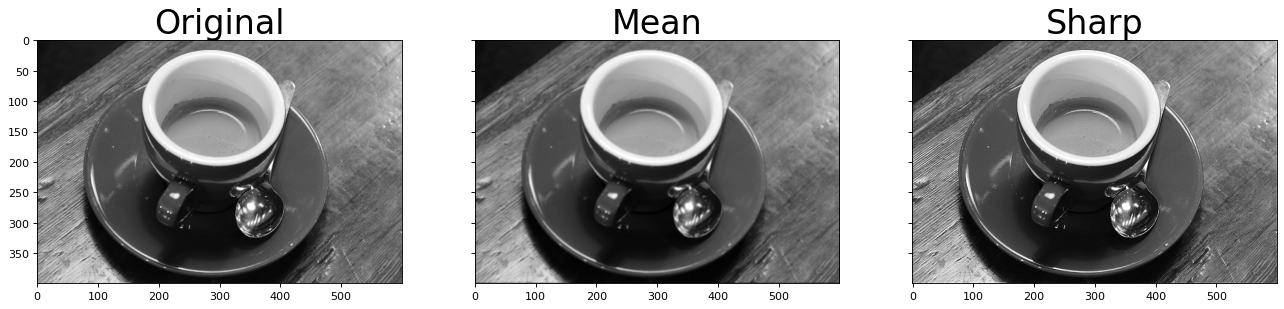

In [175]:
nothing = np.array([
    [1., ],
])

mean = np.array([
    [1, 1, 1, ],
    [1, 1, 1, ],
    [1, 1, 1, ],
]) / 9

sharp = np.array([
    [0, -1, 0, ],
    [-1, 9, -1, ],
    [0, -1, 0, ],
]) / 5

filters = [nothing, mean, sharp, ]
lst_title = ['Original', 'Mean', 'Sharp', ]

fig, axes = plt.subplots(
    ncols=len(lst_title),
    sharex=True,
    sharey=True,
    figsize=(20, 10),
    dpi=80,
)
for i in range(len(filters)):

    filtered_img = cv2.filter2D(
        src=img,
        kernel=filters[i],
        ddepth=-1, #the same depth as input
        borderType=cv2.BORDER_CONSTANT,
        anchor=(-1, -1), #center of the kernel
        delta=0, #additional data added to
    )

    axes[i].imshow(filtered_img, cmap='gray')
    axes[i].set_title(lst_title[i], fontsize=30)

Особенность свертки - ее локальность. Чем больше ядро светки - тем в большей окрестности она охватывает пиксели.

# Вопрос

Проанализируйте спектр и фазы зашумленных сигналов после применения фильтров. Что изменилось?

**Ответ:**
После применения фильтров спектр и фазы зашумленных сигналов могут измениться. Например, фильтр сглаживания (mean) может уменьшить высокочастотные компоненты сигнала, что приведет к снижению шума. Фильтр резкости (sharp) может увеличить высокочастотные компоненты, что может усилить шум. Эти изменения зависят от характеристик самого фильтра и свойств исходного сигнала.


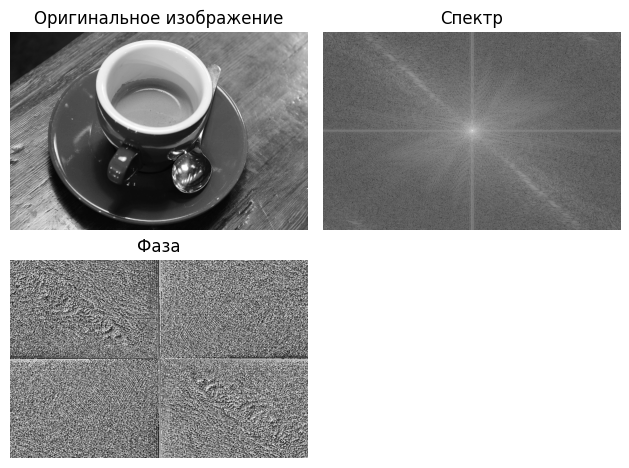

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузим изображение
img = cv2.cvtColor(
    src=data.coffee(),
    code=cv2.COLOR_RGB2GRAY,
)

# Вычислим спектр и фазу ОРИГИНАЛ
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20  *  np.log(np.abs(fshift))
phase_spectrum = np.angle(fshift)



# Отобразим результаты
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Оригинальное изображение')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фаза')
plt.axis('off')

plt.tight_layout()
plt.show()



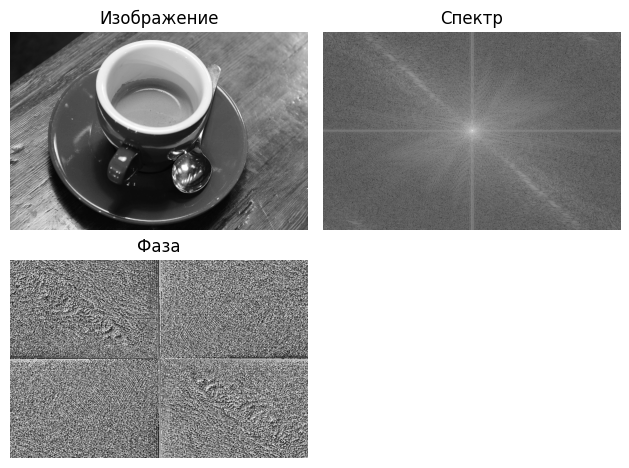

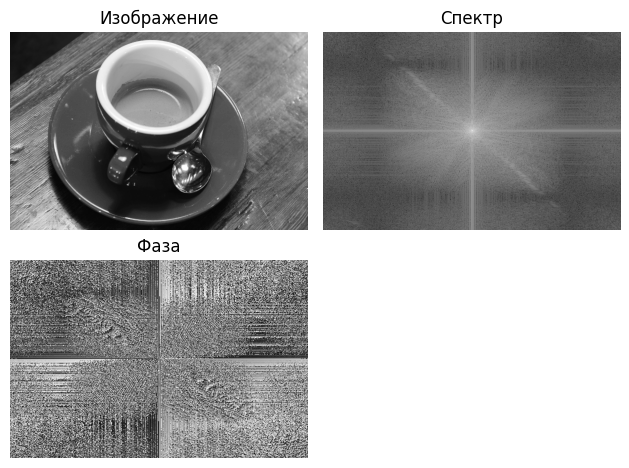

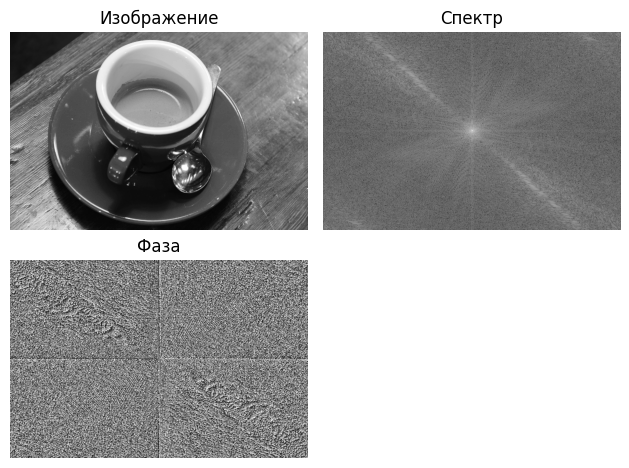

In [177]:
# фильтры
nothing = np.array([[1.]])
mean = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) / 5

# Применим фильтры к изображению
filtered_images = [cv2.filter2D(img, -1, kernel) for kernel in [nothing, mean, sharp]]

for i in filtered_images:
    # Вычислим спектр и фазу ФИЛЬТРЫ
    f = np.fft.fft2(i)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20  *  np.log(np.abs(fshift))
    phase_spectrum = np.angle(fshift)

    # Отобразим результаты
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Изображение')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Спектр')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(phase_spectrum, cmap='gray')
    plt.title('Фаза')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Упражение 3

Реализуйте свою свертку и сравните с реализацией `cv2.filter2D` (визуализируйте результаты работы своей свертки и библиотечной с одинаковым ядром + посмотрите на разность значений пикселей после обработки).

In [178]:
def my_convolution(image, kernel):
    m, n = image.shape
    k, l = kernel.shape
    output = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for x in range(k):
                for y in range(l):
                    if i-x < 0 or j-y < 0 or i-x >= m or j-y >= n:
                        output[i, j] += 0
                    else:
                        output[i, j] += image[i-x, j-y] * kernel[x, y]
    return output

Здесь создаем новое изображение и проходимся по каждому пикселю исходного изображения, чтобы вычислить значение нового пикселя на основе ядра. Если пиксель выходит за пределы изображения, мы его игнорируем (output[i, j] += 0). Иначе вычисляем значение пикселя, умножая значение пикселя изображения на соответствующее значение ядра и добавляя его к общему результату.

Теперь сравним нашу реализацию свертки с функцией cv2.filter2D:

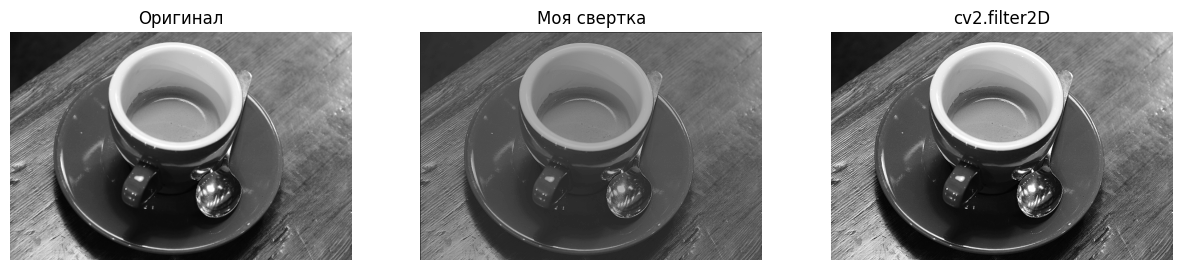

Разница:
[[1.500e+01 1.800e+01 1.400e+01 ... 2.282e+02 2.332e+02 2.298e+02]
 [1.800e+01 6.000e+00 3.400e+00 ... 3.960e+01 3.360e+01 4.280e+01]
 [1.800e+01 1.000e+00 2.000e-01 ... 6.600e+00 2.000e-01 2.400e+00]
 ...
 [1.494e+02 3.420e+01 1.240e+01 ... 3.400e+00 2.620e+01 1.000e+01]
 [1.956e+02 4.600e+00 3.220e+01 ... 2.200e+01 2.660e+01 2.380e+01]
 [1.830e+02 5.180e+01 4.200e+00 ... 4.400e+00 1.040e+01 4.000e+00]]


In [179]:
# изображение
image = cv2.cvtColor(
    src=data.coffee(),
    code=cv2.COLOR_RGB2GRAY,
)

# Создаем ядро (фильтр)
kernel = np.array([
    [0, -1, 0, ],
    [-1, 9, -1, ],
    [0, -1, 0, ],
]) / 5

# Применяем свою реализацию свертки
my_filtered_image = my_convolution(image, kernel)
# Применяем функцию cv2.filter2D
cv2_filtered_image = cv2.filter2D(image, -1, kernel)

# Визуализируем результаты
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Оригинал')
plt.axis('off')
plt.subplot(132)
plt.imshow(my_filtered_image, cmap='gray')
plt.title('Моя свертка')
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2_filtered_image, cmap='gray')
plt.title('cv2.filter2D')
plt.axis('off')
plt.show()

# Посмотрим на разность значений пикселей после обработки
difference = np.abs(my_filtered_image - cv2_filtered_image)
print('Разница:')
print(difference)


Рассмотрим нелинейные фильтры. Многие из них нелокальны и адаптивны.

1. Медианный фильтр
```python
filtered_img = cv2.medianBlur(
      src=img,
      ksize=(5, 5), #kernel size
)
```
2. Гистограмное выравнивание
```python
filtered_img = cv2.equalizeHist(
      src=img,
)
```
3. Contrast Limited Adaptive Histogram Equalization (CLAHE). Описание [англ](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE)
```python
clahe = cv2.createCLAHE(
      clipLimit=40.0, # Threshold for contrast limiting
      tileGridSize=(8, 8),  # Grid size
)
filtered_img = clahe.apply(img)
```
4. Билатеральный фильтр. Описание [англ](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html), [рус](https://habr.com/ru/post/273159/)
```python
filtered_img = cv2.bilateralFilter(
      src=img,
      d=9, #Diameter of each pixel neighborhood
      sigmaColor=75,  #Filter sigma in the color space
      sigmaSpace=75, #Filter sigma in the coordinate space
      borderType=cv2.BORDER_CONSTANT,
)
```

Разберем подробнее 

# Гистограмное Выравнивание

Рассмотрим изображение, значения пикселей которого ограничены только определенным диапазоном значений. Например, на более ярком изображении все пиксели будут ограничены высокими значениями. Но хорошее изображение будет содержать пиксели из всех областей изображения. Поэтому вам нужно растянуть эту гистограмму до обоих концов, и это то, что делает выравнивание гистограммы (простыми словами). Обычно это улучшает контрастность изображения.

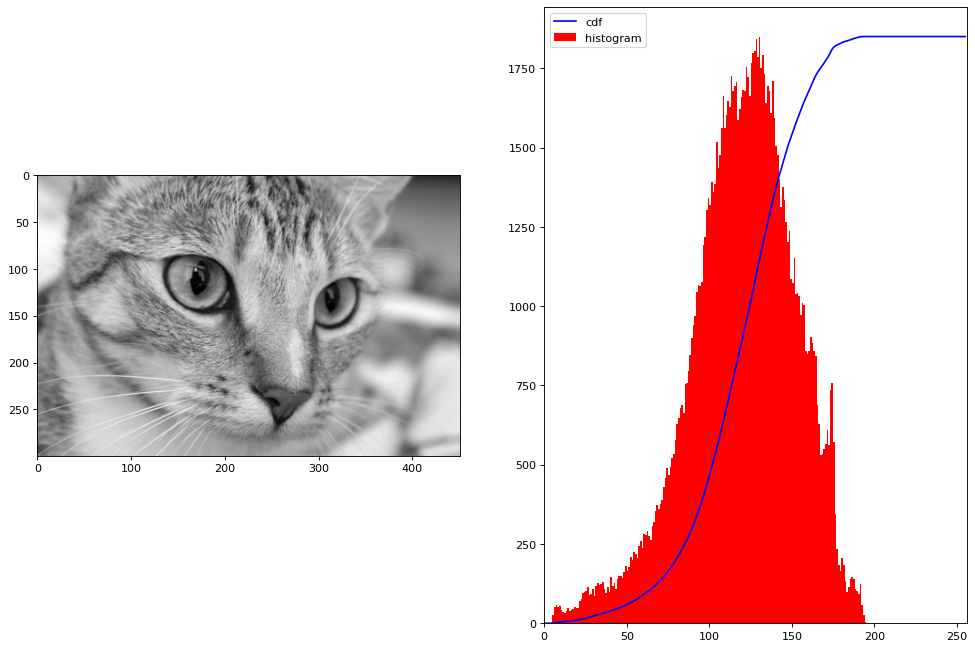

In [180]:
img = cv2.cvtColor(
    src=data.cat(),
    code=cv2.COLOR_RGB2GRAY,
)

def plot_hist(
    img: np.array,
) -> None:

    fig, axes = plt.subplots(
        ncols=2,
        figsize=(15, 10),
        dpi=80,
    )

    axes[0].imshow(
        img,
        cmap='gray',
    )

    hist, bins = np.histogram(
        a=img.flatten(),
        bins=256,
        range=[0,256],
    )
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    axes[1].plot(
        cdf_normalized,
        color='b',
    )
    axes[1].hist(
        x=img.flatten(),
        bins=256,
        range=[0,256],
        color='r',
    )
    axes[1].set_xlim([0,256])
    axes[1].legend(
        ('cdf','histogram'),
        loc='upper left',
    )

def plot_unhist(
    img: np.array,
) -> None:

    hist, bins = np.histogram(
        a=img.flatten(),
        bins=256,
        range=[0,256],
    )
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(
        x=cdf,
        value=0,
    )
    cdf_m = (cdf_m - cdf_m.min())/(cdf_m.max() - cdf_m.min()) * 255

    cdf = np.ma.filled(
        a=cdf_m,
        fill_value=0,
    )

    cdf = cdf.astype(np.uint8)

    img2 = cdf[img]

    plot_hist(img2)

plot_hist(img)

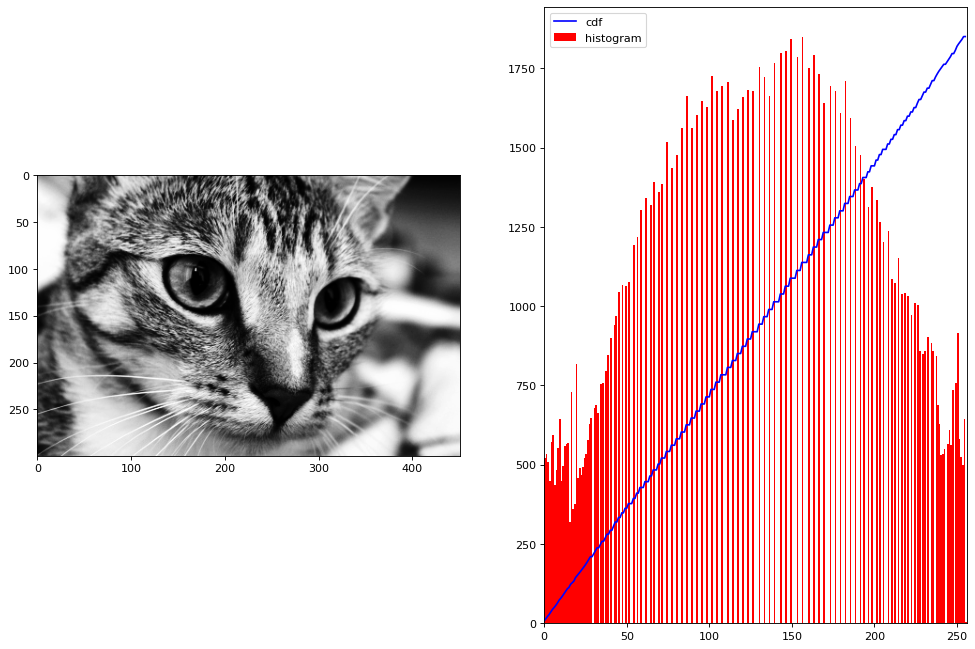

In [181]:
plot_unhist(img)

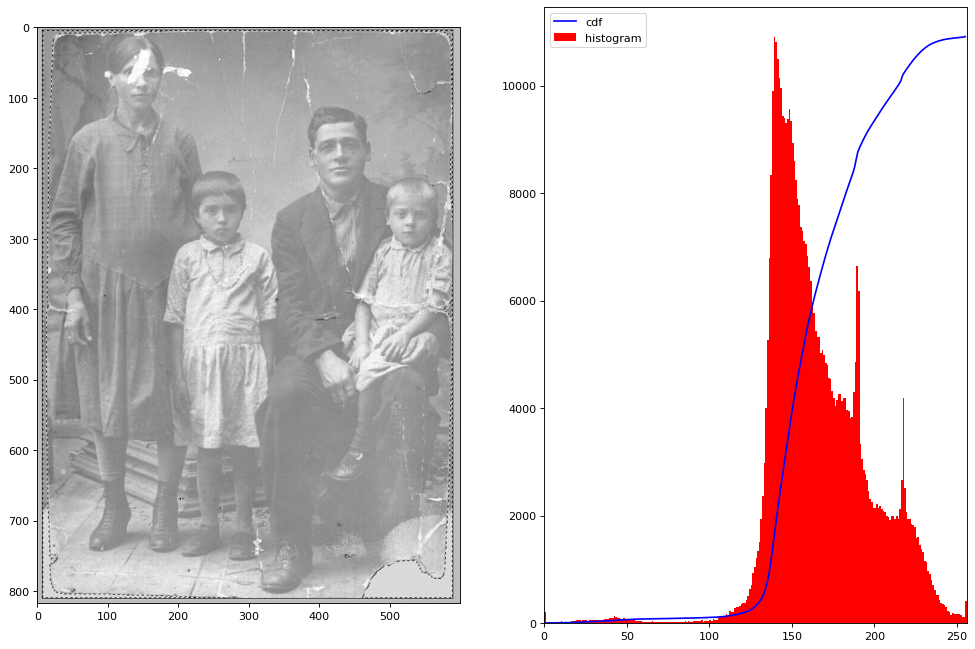

In [182]:
IMG_PATH = "data/image.jpg"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_03/data .

img = cv2.cvtColor(
    src=cv2.imread(IMG_PATH),
    code=cv2.COLOR_RGB2GRAY,
)

plot_hist(img)

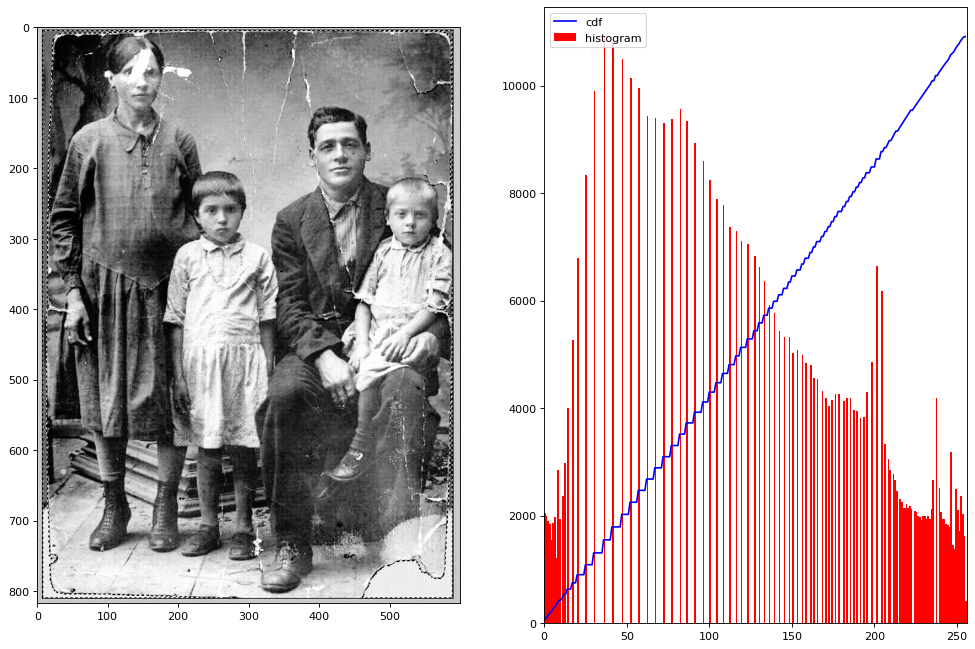

In [183]:
plot_unhist(img)

# Упражнение 4

Примените адаптивное гистограммное выравнивание CLAHE (используйте `cv2`), сравните результат с тем, что получалось при обычном гистограммном выравнивании.

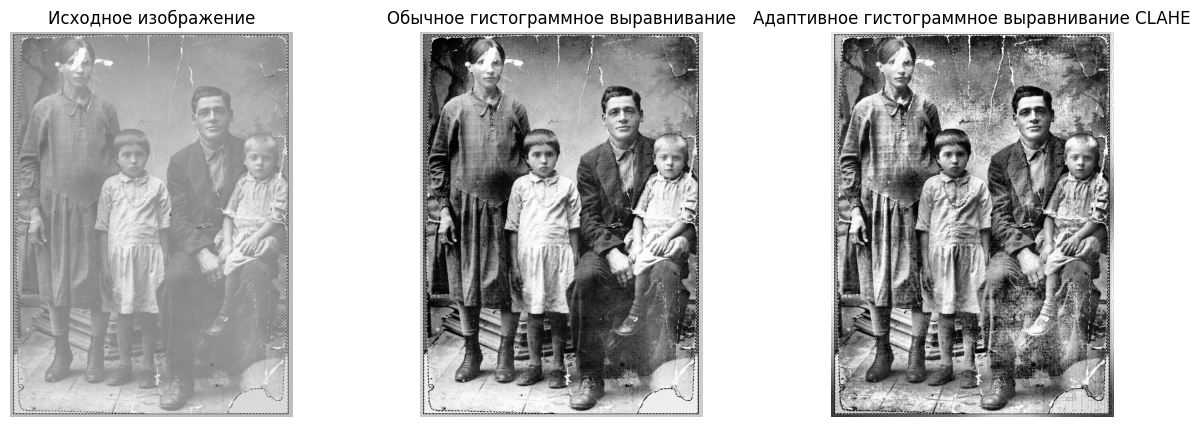

In [187]:
# Загружаем изображение
img = cv2.imread('data/image.jpg')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Применяем обычное гистограммное выравнивание
equ = cv2.equalizeHist(img_gray)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))

# Применяем адаптивное гистограммное выравнивание CLAHE
clahe_img = clahe.apply(img_gray)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Отображаем
axs[0].imshow(img_gray, cmap='gray')
axs[0].set_title('Исходное изображение')

axs[1].imshow(equ, cmap='gray')
axs[1].set_title('Обычное гистограммное выравнивание')

axs[2].imshow(clahe_img, cmap='gray')
axs[2].set_title('Адаптивное гистограммное выравнивание CLAHE')

for ax in axs:
    ax.axis('off')

plt.show()